<center>机器学习-第一次作业<br>
第二组工程文件</center>

In [1]:
#请输入CSV文件目录以更改数据集
csv_path = 'Data\\Advertising_train.csv'

In [2]:
#模型训练模式
#当Regularation_Enabled == True时，模型使用正则化方法训练并分析
#当Regularation_Enabled == False时，模型使用梯度下降方法训练并分析
Regularation_Enabled = False

In [3]:
#这个cell提供了两个可供更改的参数，修改参数可能影响模型训练的参数和性能
MAX_ITERATION_LOOPS = 30000 #拟合模型的最大循环次数
DESCENT_DROP_VALUE = 0.00001 #认为梯度不再下降，停止拟合的最小值

In [4]:
#运行本notebook需要以下库，如本cell报错，请先安装库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from sklearn.model_selection import KFold

<center>模型与定义部分</center>

In [5]:
def Distribution_plot(dataf,title): #这个函数用于直观的展现预处理的结果
    colors = {"TV": 'r', "radio": 'b', "newspaper": 'g'}
    legn = []
    plt.figure(figsize=(16, 8))
    for tmps in dataf.columns:
        if tmps != "sales":
            plt.scatter(dataf[tmps], dataf["sales"], s=5, c=colors[tmps])
            legn.append(tmps)
    
    plt.legend(legn)#修改坐标轴和图例
    plt.ylabel("Sales")
    plt.xticks(range(0, 300, 20))
    plt.title(title)
    plt.show()

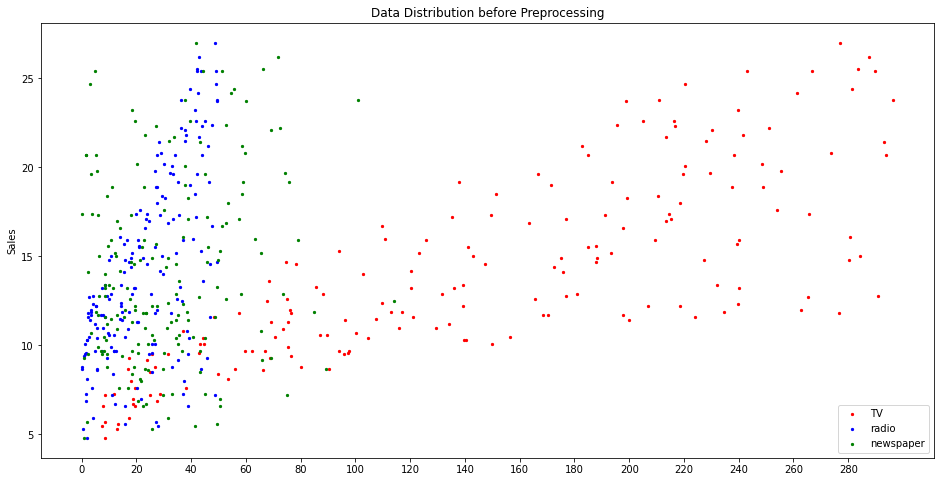

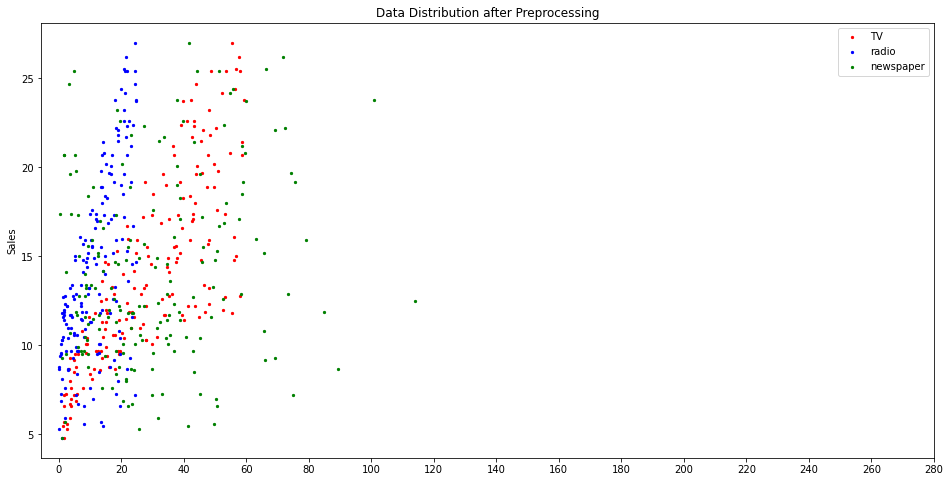

In [6]:
sourcedata = pd.read_csv(csv_path,header=0,index_col=0) #读入csv
Distribution_plot(sourcedata,"Data Distribution before Preprocessing")
ip_x = np.array(sourcedata[['TV','radio','newspaper']])
ip_y = np.array(sourcedata[['sales']]) #读入元数据并画出数据离散图

changedata = sourcedata
changedata['TV']/=5
changedata['radio']/=2
Distribution_plot(changedata,"Data Distribution after Preprocessing") #处理后画出数据离散图

In [7]:
def MSE_Calculation(tocal_x,tocal_y,param_omega): #均方误差计算函数，输入x向量与y向量，以及输入omega列向量
    toadd = 5*np.ones(len(tocal_x))
    tocal_x=np.insert(tocal_x,3,values=toadd,axis=1)
    MSE_result = np.matmul((tocal_y-np.matmul(tocal_x,param_omega)).T,tocal_y-np.matmul(tocal_x,param_omega))
    return MSE_result[0][0]

def GRA_Calculation(tocal_x,tocal_y,param_omega): #梯度计算，输入x向量与y向量，以及输入omega列向量
    toadd = 5*np.ones(len(tocal_x))
    tocal_x=np.insert(tocal_x,3,values=toadd,axis=1)
    GRA_result = np.matmul(2*tocal_x.T,np.matmul(tocal_x,param_omega)-tocal_y)
    return GRA_result

def x_preprocess(x_t): #快速对符合格式的input_x作预处理
    ret = x_t
    ret[:,0]/=5
    #ret[:,0] = np.sqrt(ret[:,0])#这个代码的特别之处在于这里，将第一列取根号之后，造成了均方误差的骤降
    ret[:,2]/=2
    return ret

In [8]:
#相同的模型，使用正则化方法直接对omega进行解析，翻自吴泽辉dalao
class Regularation_Model():
    def __init__(self,inputx,inputy):
        self.tempinput_x = x_preprocess(inputx)
        self.input_x = 5*np.ones(shape=(np.shape(self.tempinput_x)[0],np.shape(self.tempinput_x)[1]+1))
        self.input_x[:,0:3] = self.tempinput_x
        self.input_y = inputy
        self.omega_analytic = np.zeros(shape=(4,1))
        
    def train(self):
        index = 0 #正则化系数
        minvalue = 100000
        for itt in range(0,90001):
            k = 1e-7 + itt*1e-11
            n = np.eye(4)*k
            n[0]=0
            omega_process = np.matmul(np.matmul(np.linalg.inv(np.matmul((self.input_x).T,self.input_x)+n),(self.input_x).T),self.input_y)
            tocomp = MSE_Calculation(self.tempinput_x,self.input_y,omega_process)
            if minvalue>tocomp:
                minvalue = tocomp
                index = k
                self.omega_analytic = omega_process
    
    def show_match_parameter(self): #绘制最终结果
        print('拟合的omega:',end='')
        print((self.omega_analytic).reshape(1,-1)[0])
        print('最终均方误差：%f'%MSE_Calculation(self.tempinput_x,self.input_y,self.omega_analytic))
    
    def getomegatrained(self): #返回训练得到的参数
        return self.omega_analytic
            

In [9]:
#多元线性回归模型拟合，代码翻译自吴泽辉dalao
class Linear_Regression_Model():
    def __init__(self,inputx,inputy):
        self.omegaprocess=np.zeros(shape=(4,1,MAX_ITERATION_LOOPS+2)) #历次迭代中计算的omega
        self.omegaprocess[:,:,0]=[[0.1],[0.1],[0.1],[0.1]] #初始omega
        self.MSE_descent=[] #均方误差下降的大小
        self.MSE_list=[] #每次迭代的均方误差
        self.Descent_step=[] #每次迭代的学习步长
        self.input_x = x_preprocess(inputx)
        self.input_y = inputy
        self.totaliterations = 0 #总共迭代的次数

    def train(self):
        iterations=0 #迭代次数
        while iterations<=(MAX_ITERATION_LOOPS-1):
            iterations+=1 #迭代一次
            MSE_in_loop = MSE_Calculation(self.input_x,self.input_y,self.omegaprocess[:,:,iterations-1]) #计算梯度和均方误差
            GRA_in_loop = GRA_Calculation(self.input_x,self.input_y,self.omegaprocess[:,:,iterations-1])
            MSE_tostat_MIN = 1e12
            Effi_index = 0

            for i in range(1,101): #一维搜索确定步长
                omegapredict = self.omegaprocess[:,:,iterations-1] - (0.0001/i)*GRA_in_loop
                msetemp = MSE_Calculation(self.input_x,self.input_y,omegapredict)
                if (msetemp<MSE_tostat_MIN):
                    Effi_index=i
                    MSE_tostat_MIN = msetemp
            
            self.Descent_step.append(Effi_index) #记录学习步长
            self.omegaprocess[:,:,iterations] = self.omegaprocess[:,:,iterations-1] - (0.0001/Effi_index) * GRA_in_loop #参数omega进行迭代
            self.MSE_descent.append(abs(MSE_Calculation(self.input_x,self.input_y,self.omegaprocess[:,:,iterations])-MSE_in_loop)) #记录梯度下降量
            self.MSE_list.append(MSE_in_loop)
            if (self.MSE_descent[-1]<DESCENT_DROP_VALUE): break 
        self.totaliterations = iterations
    
    def show_match_parameter(self): #绘制最终结果
        print('拟合的omega:',end='')
        print(self.omegaprocess[:,:,self.totaliterations].reshape(1,-1)[0])
        print('最终均方误差：%f'%self.MSE_list[-1])
        print('累计迭代次数：%d'%self.totaliterations)
        
    def plot_training_parameters(self): #绘制训练参数图
        plt.figure(figsize=(15,6),dpi=80)
        plt.subplot(1,2,1)
        plt.plot(self.MSE_descent)
        plt.xscale('log')
        plt.yscale('log')
        plt.title("MSE Descent Value in every iteration")
        plt.subplot(1,2,2)
        plt.plot(self.MSE_list)
        plt.xscale('log')
        plt.title("MSE Value in every iteration")
        plt.show()
    
    def getomegatrained(self): #返回训练得到的参数
        return self.omegaprocess[:,:,self.totaliterations]

    def getfinalMSE(self): #返回最后的均方误差
        return self.MSE_list[-1]

<center>数据验证，模型训练与十折运算验证部分</center>

In [10]:
def tenfold_division(path): #对于path中的文件进行十折划分
    csvFile = open(path, "r")
    reader = csv.reader(csvFile)
    xy = []
    m = 0
    for row in reader:
        lr = len(row)
        if m != 0:
            for i in range(lr):
                row[i] = float(row[i])
            xy.append(row[1:lr])
        m += 1
    xy = np.array(xy)
    kf = KFold(n_splits=10, shuffle=False)
    x_tr = []
    y_tr = []
    x_te = []
    y_te = []
    for train_index, test_index in kf.split(xy):
        xy_tr, xy_te = xy[train_index], xy[test_index]
        x_tr.append(xy_tr[:, 0:3])
        y_tr.append(xy_tr[:, 3])
        x_te.append(xy_te[:, 0:3])
        y_te.append(xy_te[:, 3])
    return x_tr,y_tr,x_te,y_te

In [11]:
x_train,y_train,x_test,y_test = tenfold_division(csv_path)

if (Regularation_Enabled == True): print("【模型运行模式】正则化方法（直接解析omega)")
else: print("【模型运行模式】梯度下降法")

MSE_tenfold=[]
for i in range(1,11):#对十折后的数据集分别建立模型并分析，将数据存储
    if (Regularation_Enabled == True):
        themodel = Regularation_Model(x_train[i-1],np.array(y_train[i-1]).reshape(-1,1))
    else:
        themodel = Linear_Regression_Model(x_train[i-1],np.array(y_train[i-1]).reshape(-1,1))
    themodel.train()
    print("\n----------【十折训练组：%d】----------"%i)
    themodel.show_match_parameter()
    MSE_tenfold.append(MSE_Calculation(x_preprocess(x_test[i-1]),np.array(y_test[i-1]).reshape(-1,1),themodel.getomegatrained()))
    print("使用本组计算参数计算的测试数据均方误差:%f" %MSE_tenfold[-1])
    if (Regularation_Enabled == False):
        themodel.plot_training_parameters()

print("\n----------【十折训练集总结】-----------")
print("十折交叉验证的平均测试均方误差：%f"%np.mean(MSE_tenfold))
print("\n----------【训练组：全数据模型】-----------")

if (Regularation_Enabled == True): defaultmodel = Regularation_Model(ip_x,ip_y)
else: defaultmodel = Linear_Regression_Model(ip_x,ip_y)
defaultmodel.train()
defaultmodel.show_match_parameter()
if (Regularation_Enabled == False): defaultmodel.plot_training_parameters()

【模型运行模式】正则化方法（直接解析omega)

----------【十折训练组：1】----------
拟合的omega:[ 0.22872795  0.1882836  -0.01271376  0.66753996]
最终均方误差：316.624299
使用本组计算参数计算的测试数据均方误差:101.646131

----------【十折训练组：2】----------
拟合的omega:[ 0.22676439  0.18978746 -0.01440776  0.67733246]
最终均方误差：373.493413
使用本组计算参数计算的测试数据均方误差:44.030880

----------【十折训练组：3】----------
拟合的omega:[ 0.21900338  0.18862361 -0.01628637  0.71972221]
最终均方误差：374.267503
使用本组计算参数计算的测试数据均方误差:44.376062

----------【十折训练组：4】----------
拟合的omega:[ 0.21949034  0.19242703 -0.01465125  0.69457646]
最终均方误差：359.364569
使用本组计算参数计算的测试数据均方误差:58.500233

----------【十折训练组：5】----------
拟合的omega:[ 0.22561051  0.19316964 -0.01731496  0.65193535]
最终均方误差：398.444516
使用本组计算参数计算的测试数据均方误差:19.279666

----------【十折训练组：6】----------
拟合的omega:[ 0.22265428  0.19207636 -0.00926556  0.65275286]
最终均方误差：377.511976
使用本组计算参数计算的测试数据均方误差:40.372866

----------【十折训练组：7】----------
拟合的omega:[ 0.22458194  0.18900889 -0.01545716  0.67667274]
最终均方误差：400.461487
使用本组计算参数计算的测试数据均方误差:16.613959

-------